# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Sample Code

Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 358914272.000


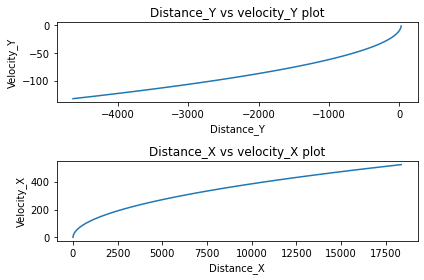

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 326058656.000


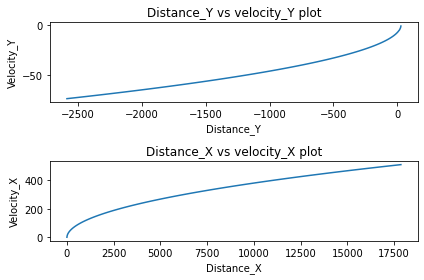

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 309872032.000


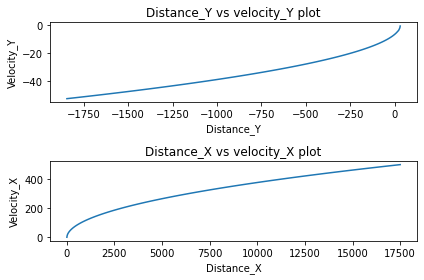

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 297553504.000


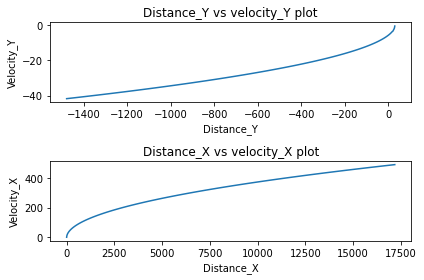

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 287142400.000


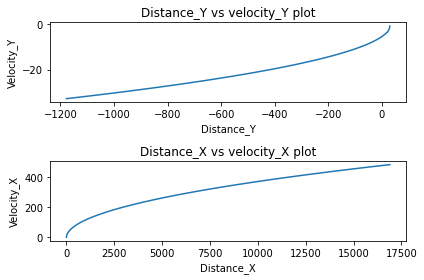

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 278698528.000


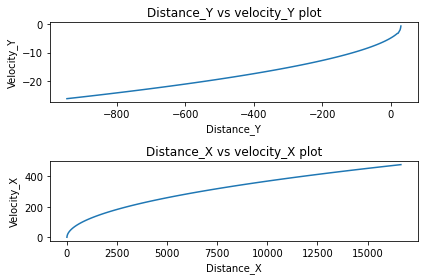

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 271720064.000


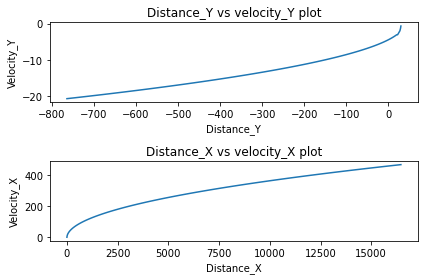

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 266051360.000


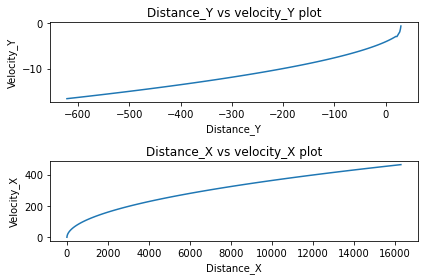

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 261266688.000


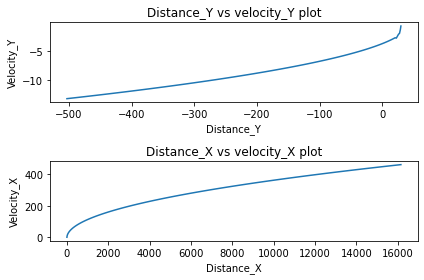

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 256389920.000


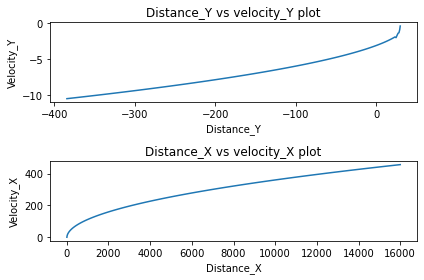

In [4]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

"""






                              OPTIMIZATION OF DYNAMIC MODEL OF AN ATLAS V ROCKET..
                              
                              
                              
                              
                              
                              





This is the problem formualtion of Atlas V rocket of NASA and the paramaters and dimensions have been considered from the 
website of NASA. I have manipulated the distance function and optimized it accordingly by verifying the loss pattern.

Hence this is a new dynamic model of Atlas V rocket


I have experimented a set of neural networks and successfully optimized the loss..

Although the loss is higher intially which is due to the reason that I don't consider the complete physics behind the model,
It makes sense when the loss is decreasing which tells us the our optimization is successfull..




I have calculated the Aerodynamic drag force and Mach Number ..

Mach Number signifies the type of the flow..
it can be Sonic , Supersonic stc..




"""

logger = logging.getLogger(__name__)
FRAME_TIME = 0.7  # Time Interval taken by the Rocket between 2 states..
GRAVITY_ACCEL = 9.81  # gravity constant g = 9.8 m/s^2
ACC_BOOST = 20


class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action[0] = Linear_Thrust in y
        action[1] = Linear_Thrust in x
        state[0] = y
        state[1] = y_differential
        state[2] = x
        state[3] = x_differential
        """

        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...

        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])  # Converting to 2D

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_y = ACC_BOOST * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]  # Converting to 2D in y

        delta_state_x = ACC_BOOST * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]  # converting to 2D in x

        temp = delta_state_y

        """"
        In the given rocket landing scenario, the lift force of the rocket is being calculated

        Aerodynamic_Drag_force: D = Cd * Area_wing * .5 * r * V^2
        Atlas rocket is being considered in the scenario
        Cd = 0.75 (Drag co-efficient)
        The diameter of the Atlas v rocket is 3.8 m,
        Area = pi * 1.9 m ^2  = 11.33 m^2
        r = 850 kg/m^3 (Density of steel)
        V = velocity = delta_state
               m = 590000 Kg (Weight of Atlas V rocket)

               D = 0.75 * 11.33 * 0.5 * 850 * delta_state**2
               Let me assume the velocit as 10 m/s^2

               also applying force balance on the rocket

               m * DRAG_ACC (Negative acceleration due to gravity) = D
               DRAG_ACC = 0.00612 * delta_state**2
               
               
               
               Mach Number 
               M = velocity of sound/ velocity of the rocket
               
               The values of M are not printed as it is increasing the complexity..
               But the code is working fine with it..I have commented the Mach Number part after the velocity state for your ref..

               """
        # Aerodynamic Drag Updation
        DRAG_ACC = 0.00612 * temp * temp

        ACC_NET = ACC_BOOST - DRAG_ACC  # Updating net accel in Y

        # Re-calculating new velocity in Y
        
        delta_state_y = ACC_NET * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]

        # Update velocity
        
        state = state + delta_state_y + delta_state_gravity + delta_state_x
        
        
        """
        # MACH NUMBER CALCULATION
        
        M = 332 / state
        
        """
        
        

        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                             [0., 1., 0., 0.],
                             [0., 0., 1., FRAME_TIME],
                             [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        
        
        I have experimented the neural networks 
        By sarting with a simple step..
        I went on using as per nn.sequential
        
        
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Sigmoid(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Sigmoid(),
        )

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        """
        I have considered an Atlas V landing at a site and it is approximately at 30m from the landing site,
        It is approximately at (3,0) ie 3 m to the right  with a negative velocity of 4m/s
        """
        
        state = [30., 0., 3., -4.]  #batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2


class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print(
                '_______________________________________________________________________________________________________________')
            print('\nIteration number:\t', epoch + 1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]

        plt.figure()
        plt.subplot(211)
        plt.title('Distance_Y vs velocity_Y plot')
        plt.xlabel('Distance_Y')
        plt.ylabel('Velocity_Y')
        plt.plot(x, y)

        plt.subplot(212)
        plt.title('Distance_X vs velocity_X plot')
        plt.xlabel('Distance_X')
        plt.ylabel('Velocity_X')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (a_y, a_x)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # definiton of  optimizer
o.train(10)  #10 Simulations


## 3. A Better Problem Formulation

Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 